In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
# Specify important directories
import os, sys, time, warnings, sklearn
ROOT='/kaggle/input'
# ROOT='data'clas
TRAIN_PATH= "/kaggle/input/dataset-fer/train"
TEST_PATH="/kaggle/input/dataset-fer/test"
# TRAIN_PATH=ROOT+'/fer-2013-images/train'
# TEST_PATH=ROOT+'/fer-2013-images/test'
train_angry_img_path=TRAIN_PATH +'/angry'

OVERSAMPLED_TRAIN_PATH='fed_oversampled_train'
MODEL_PATH='models'
IMAGE_PATH='images'
# Model Architecture path
def model_arch(model_name):
    # !mkdir -p images
    !mkdir images
    arch=IMAGE_PATH+'/dataset-fer_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    # !mkdir models
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".ckpt"
    return checkpoint_path

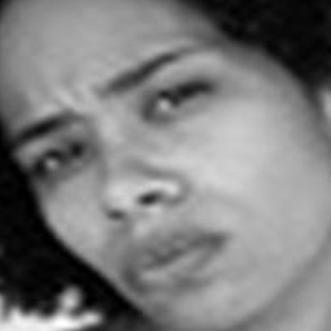

In [3]:
# Load a sample image 
# using open() to open images
image_data = Image.open("/kaggle/input/dataset-fer/train/angry/PrivateTest_12191716.jpg")
image_data

Image shape: (331, 331, 3)
Image data array: [[[ 15  15  15]
  [ 19  19  19]
  [ 25  25  25]
  ...
  [ 11  11  11]
  [ 11  11  11]
  [ 11  11  11]]

 [[ 18  18  18]
  [ 23  23  23]
  [ 29  29  29]
  ...
  [ 11  11  11]
  [ 11  11  11]
  [ 11  11  11]]

 [[ 23  23  23]
  [ 27  27  27]
  [ 33  33  33]
  ...
  [ 11  11  11]
  [ 11  11  11]
  [ 11  11  11]]

 ...

 [[223 223 223]
  [224 224 224]
  [225 225 225]
  ...
  [141 141 141]
  [142 142 142]
  [143 143 143]]

 [[225 225 225]
  [226 226 226]
  [228 228 228]
  ...
  [141 141 141]
  [142 142 142]
  [143 143 143]]

 [[228 228 228]
  [229 229 229]
  [230 230 230]
  ...
  [141 141 141]
  [142 142 142]
  [143 143 143]]]
Image array shape: (331, 331, 3)


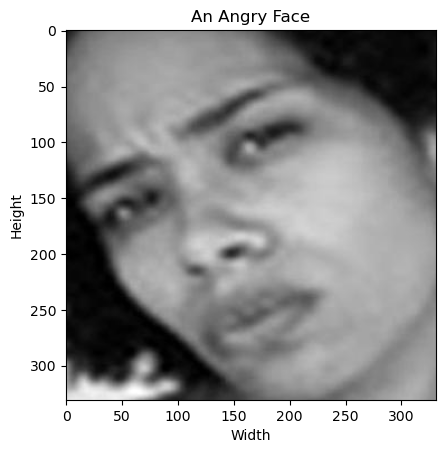

In [4]:
# Get the shape of the image
image=plt.imread("/kaggle/input/dataset-fer/train/angry/PrivateTest_12191716.jpg")
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image 
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [5]:
# Get the list of folders in the directory as classes
classes=os.listdir(TRAIN_PATH+'/')
classes

['surprise', 'fear', 'angry', 'neutral', 'sad', 'happy']

In [6]:
# Get dictionary list of image count per class
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':    
            path= TRAIN_PATH
        else:
            path= TEST_PATH
        
        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test)) 
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  


---- Train Set ----
Train class distribution:
{'surprise': 5592, 'fear': 5592, 'angry': 5592, 'neutral': 5592, 'sad': 5592, 'happy': 5592}
Average train class:  5592
Total train:  33552

---- Test Set ----
Test class distribution:
{'surprise': 1399, 'fear': 1399, 'angry': 1399, 'neutral': 1399, 'sad': 1399, 'happy': 1399}
Average test class:  1399
Total test:  8394


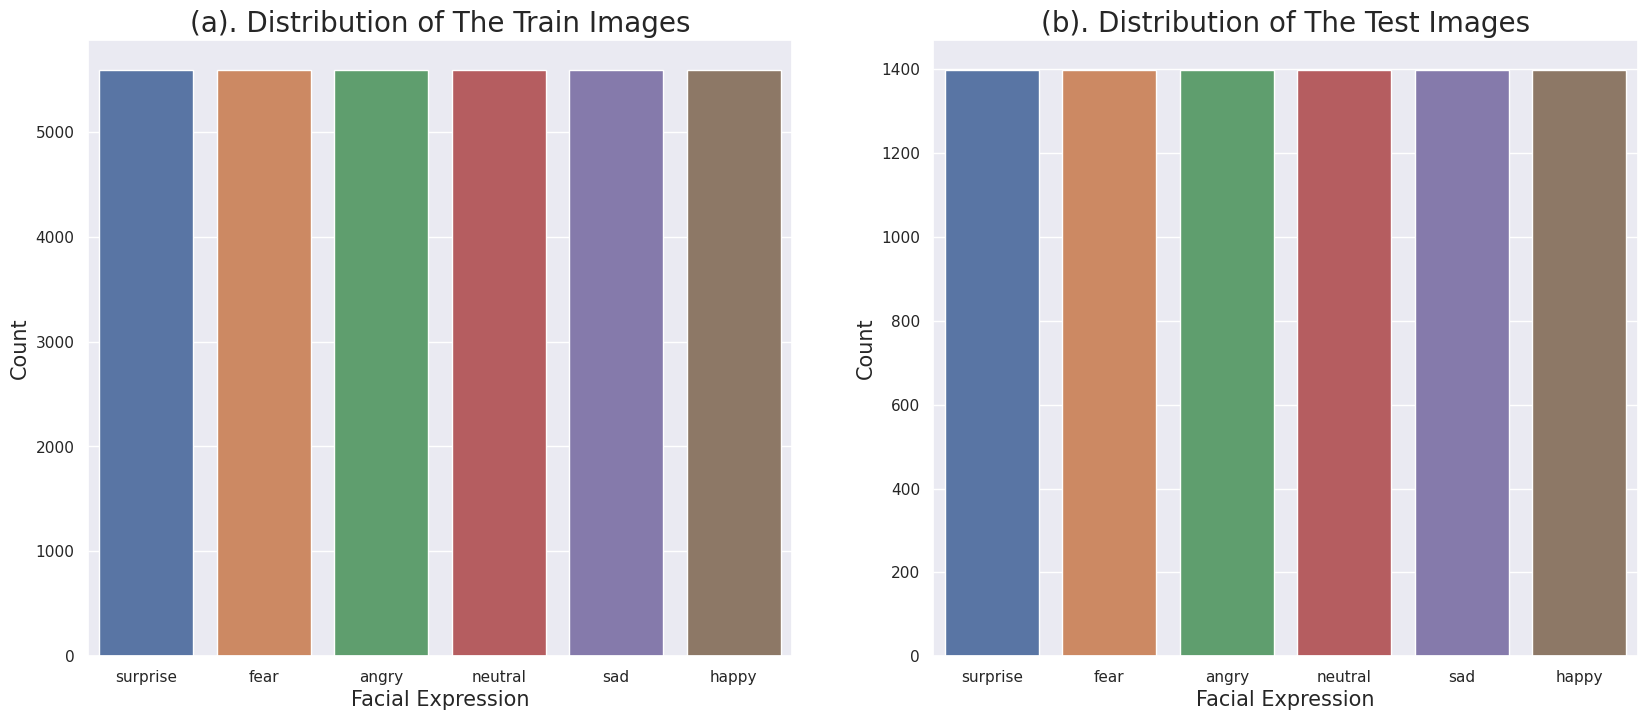

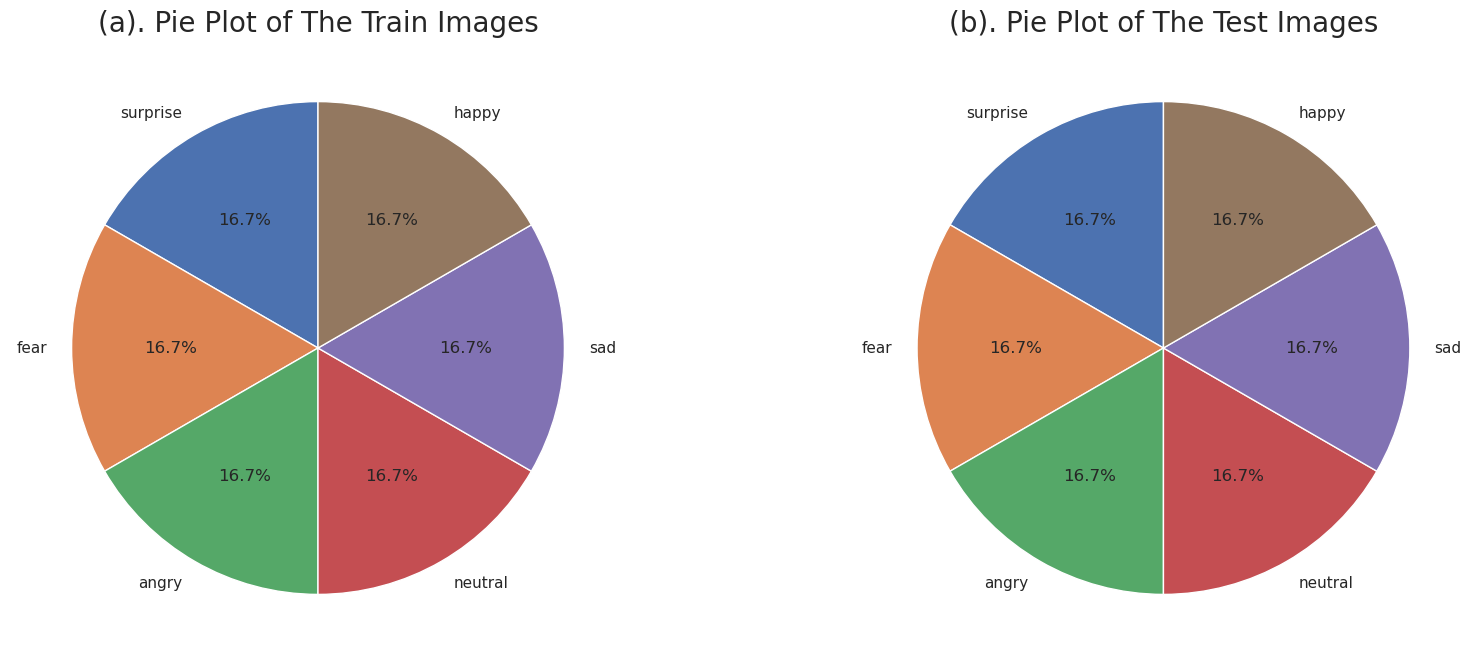

In [7]:
df_train = pds.DataFrame(list(class_sample("train")[2].items()), columns=['Emotion', 'Count'])
df_train.index.name = 'Emotion'
df_test = pds.DataFrame(list(class_sample("test")[2].items()), columns=['Emotion', 'Count'])
df_test.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_train, orient='v')
# set labels and title
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(a). Distribution of The Train Images", fontsize=20)
# plt.legend( df_train.Emotion, loc='upper left')
# set x-axis tick labels
# axis.set_xticks(range(len(df_train.Emotion)), df_train.Emotion)
# axis.yaxis.set_major_locator(ticker.MultipleLocator(2.5))

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Count', data=df_test, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(b). Distribution of The Test Images", fontsize=20)
plt.show()

print('\n\n')

x_train = npy.array([ len(os.listdir(TRAIN_PATH+'/'+class_name+'/')) for class_name in classes])
x_test = npy.array([ len(os.listdir(TEST_PATH+'/'+class_name+'/')) for class_name in classes])
label = classes
  
# plot a Pie plot with vertical orientation
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.pie(x_train, labels=label, autopct='%1.1f%%', startangle=90)
ax.set_title('(a). Pie Plot of The Train Images', fontsize=20)

ay = plt.subplot(1, 2, 2)
plt.pie(x_test, labels=label, autopct='%1.1f%%', startangle=90)
ay.set_title('(b). Pie Plot of The Test Images', fontsize=20)
plt.show()



In [8]:
# Oversampling Technique
import os
from PIL import Image

# Define the paths to the original and oversampled dataset
train_dir = TRAIN_PATH
oversampled_dir = OVERSAMPLED_TRAIN_PATH

target_length = 6991 # highest count in a class
# target_length = 4101 Average

if not os.path.exists(oversampled_dir):
    os.mkdir(oversampled_dir)

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        for i in range(num_duplicates):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{i}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

        if remainder != 0:
            for image_file in os.listdir(subfolder_path)[:remainder]:
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{num_duplicates}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)


In [9]:
# Get dictionary list of image count per class
def over_class_sample():
        filepath=OVERSAMPLED_TRAIN_PATH+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
 

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  


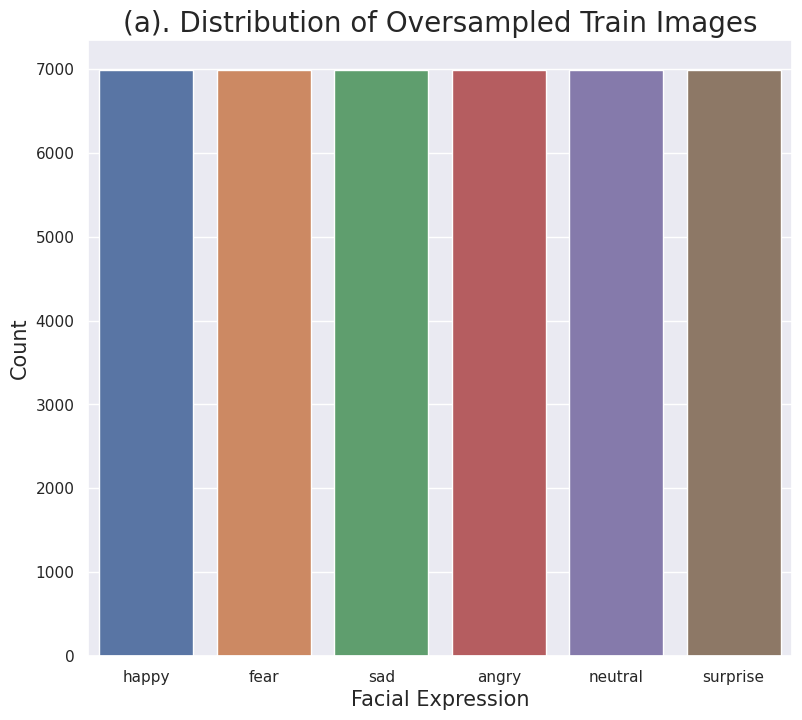


---- Oversampled Train Set ----
Train class distribution:
{'happy': 6991, 'fear': 6991, 'sad': 6991, 'angry': 6991, 'neutral': 6991, 'surprise': 6991}
Average train class:  6991
Total train:  41946


In [10]:
df_overtrain = pds.DataFrame(list(over_class_sample()[2].items()), columns=['Emotion', 'Count'])
df_overtrain.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_overtrain, orient='v')
# set labels and title
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("(a). Distribution of Oversampled Train Images", fontsize=20)
plt.show()



def test_train_distribution():
      print("\n---- Oversampled Train Set ----")
      avg_train=over_class_sample()[0]/len(over_class_sample()[1])
      print(f'Train class distribution:\n{over_class_sample()[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', over_class_sample()[0])



test_train_distribution()




In [11]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            # rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            validation_split=0.2    # set the validation split                                
                                            )


# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(
                                # rescale = 1./255,
                                )

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)


In [12]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.

classes = classes=os.listdir(TEST_PATH+'/')

## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            # directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes=classes,
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            # directory=TRAIN_PATH, 
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes= classes,
                                                            shuffle=False, 
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=False, 
                                        batch_size=test_batch_size
                                        )

## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ') 
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=True, 
                                        batch_size=test_batch_size
                                        )

Train Set Generated -  Found 33558 images belonging to 6 classes.
Validation Set Generated -  Found 8388 images belonging to 6 classes.
Test Set Generated -  Found 8394 images belonging to 6 classes.
Shuffled Test Set Generated -  Found 8394 images belonging to 6 classes.


In [13]:
# From the generator we can get information we will need later
# classes=  # os.listdir(TRAIN_PATH+'/')
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)

print(f'\nThere are 6 classes: {classes}')
print(f'The class dictionary are: {class_dictionary}')
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)
print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)

print('\ntrain_generator sample: ', train_generator.samples)
print('validation_generator sample: ', validation_generator.samples)
print('test_generator sample: ', test_generator.samples)

print('\ntrain_generator sample: ', train_generator.labels)
print('validation_generator sample: ', validation_generator.labels)
print('test_generator sample: ', test_generator.labels)


test batch size:  32   test steps:  262  number of classes :  6

There are 6 classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'happy']
The class dictionary are: {'surprise': 0, 'fear': 1, 'angry': 2, 'neutral': 3, 'sad': 4, 'happy': 5}
Class count:  6

X_train shape:  (32, 48, 48, 3)
y_train shape:  (32, 6)

X_test shape:  (32, 48, 48, 3)
y_test shape:  (32, 6)

train_generator sample:  33558
validation_generator sample:  8388
test_generator sample:  8394

train_generator sample:  [0 0 0 ... 5 5 5]
validation_generator sample:  [0 0 0 ... 5 5 5]
test_generator sample:  [0 0 0 ... 5 5 5]


In [14]:
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices}
num_images = train_generator.samples

batch_size = train_generator.batch_size
num_batches = len(train_generator)

for i in range(num_batches):
    batch = next(train_generator)
    images, labels = batch
    for j in range(len(labels)):
        label = npy.argmax(labels[j])  # convert one-hot encoding to integer label
        class_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        class_counts[class_name] += 1

print(class_counts)
print(f"Total number of images in train generator: {num_images}")

{'surprise': 5595, 'fear': 5592, 'angry': 5595, 'neutral': 5591, 'sad': 5593, 'happy': 5592}
Total number of images in train generator: 33558


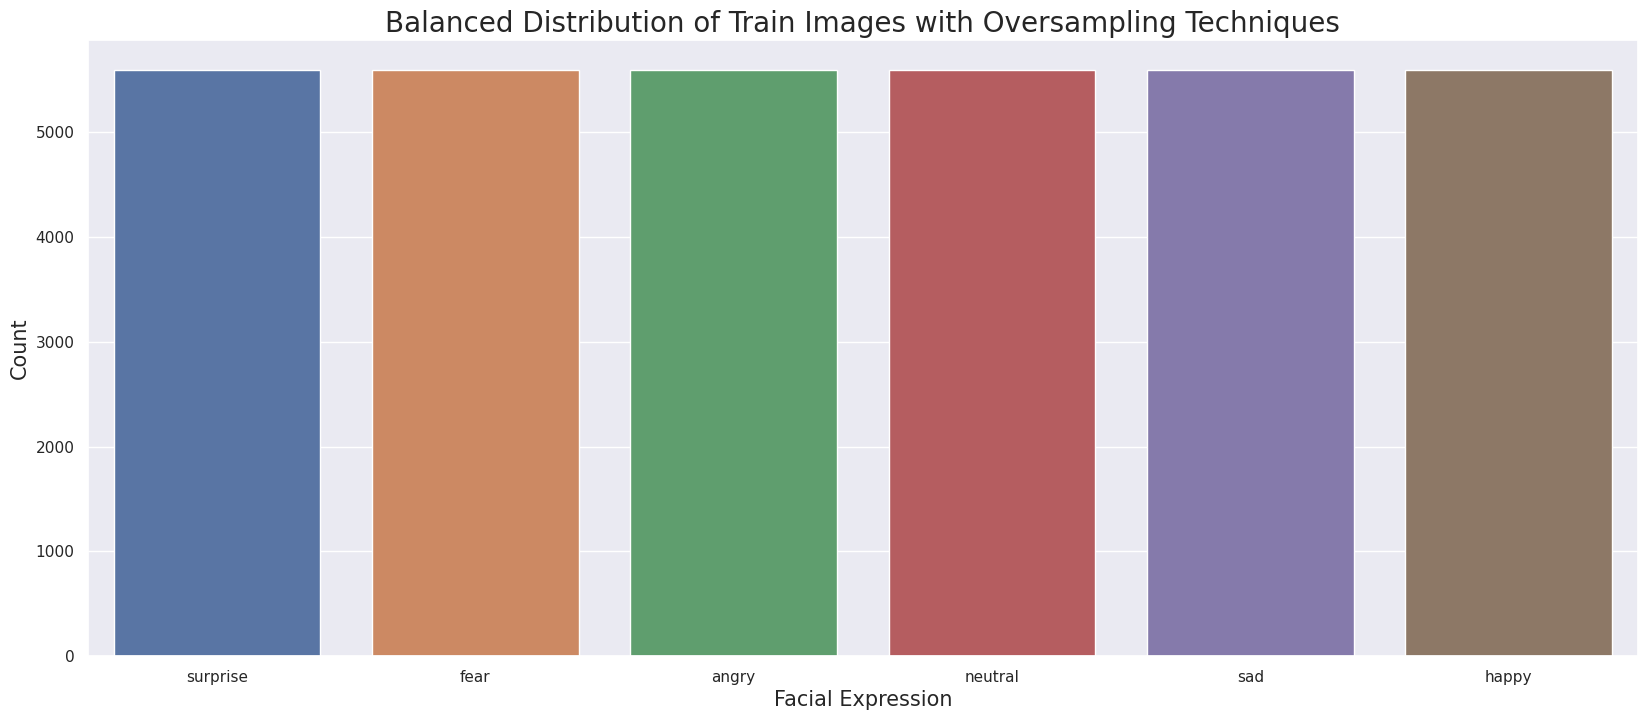

In [15]:
df_train_gen = pds.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
df_train_gen.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(20, 8))
sns.barplot(x='Emotion', y='Count', data=df_train_gen, orient='v')
plt.xlabel("Facial Expression", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Balanced Distribution of Train Images with Oversampling Techniques", fontsize=20)
plt.show()

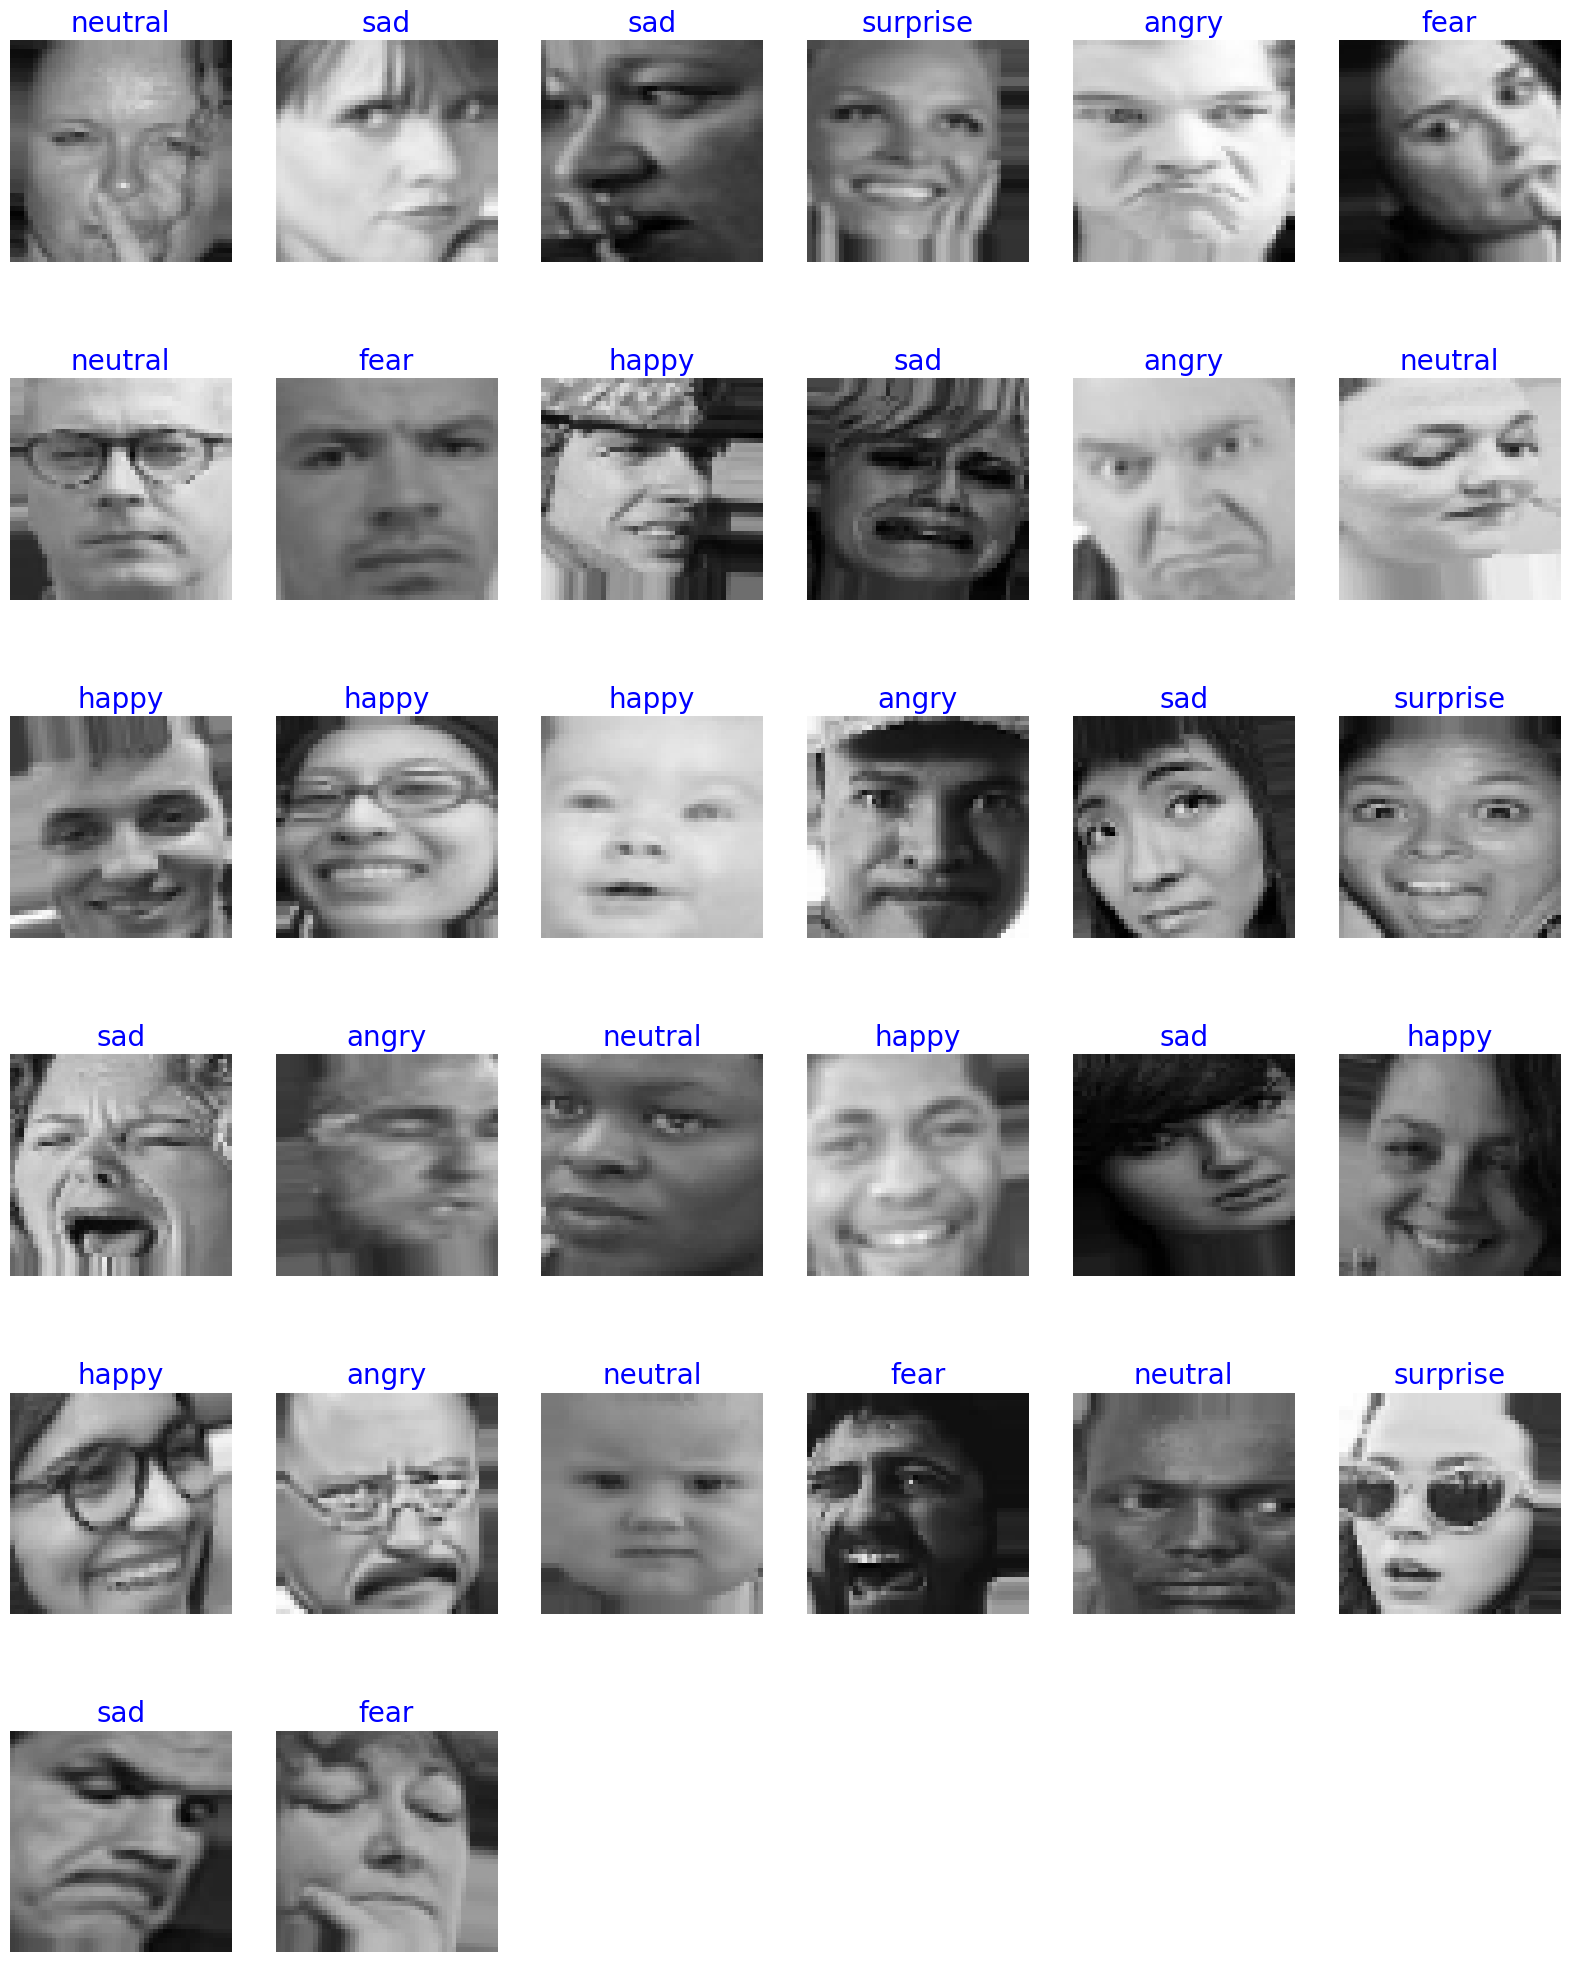

In [16]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:  
        r=length
    else:
        r=32
    for i in range(r):        
        plt.subplot(7, 6, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ", 
                    color='blue', 
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)

In [17]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy


In [18]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=60
ask_epoch=60


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
                                                            include_top=False, 
                                                            weights="imagenet",
                                                            input_shape=input_shape, 
                                                            pooling='max'
                                                            ) 

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1, 
                    momentum=0.99, 
                    epsilon=0.001,
                    name='batch_norm_x' 
                    )(x)
x = Dense(
          256, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4, 
          seed=123,
          name='dropout_x'
          )(x) 
      
output=Dense(
            class_count, 
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['normalization[0][0]']          
                    

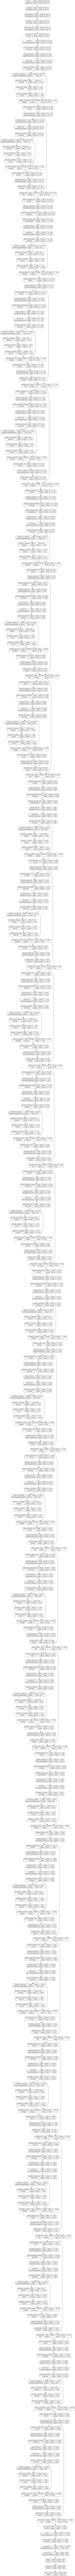

In [20]:
# Plot the Model Diagram
set_config(display="diagram")
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, to_file=model_arch(model_name), show_shapes=True)

In [21]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()
                        
                        if ans == 'Y' or ans =='y':
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        
ask=ASK(cnn_model, epochs,  ask_epoch)

In [22]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
            ask
          ]

In [23]:
model_history=cnn_model.fit(
                  train_generator,  
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None, 
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                #   validation_data=test_generator,
                # #   validation_steps=None, 
                #   validation_steps= test_generator.n//test_generator.batch_size,
                #   # shuffle=True,  
                  )


ask_epoch >= epochs, will train for  60  epochs
Training will proceed until epoch 60  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/60


2025-01-28 05:12:48.510622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1048/1048 [==============================] - ETA: 0s - loss: 5.1552 - accuracy: 0.2933
Epoch 1: val_accuracy improved from -inf to 0.39790, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1048/1048 [==============================] - 183s 118ms/step - loss: 5.1552 - accuracy: 0.2933 - val_loss: 2.6483 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 2/60
1048/1048 [==============================] - ETA: 0s - loss: 1.9864 - accuracy: 0.4191
Epoch 2: val_accuracy improved from 0.39790 to 0.48259, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1048/1048 [==============================] - 121s 116ms/step - loss: 1.9864 - accuracy: 0.4191 - val_loss: 1.5537 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 3/60
1048/1048 [==============================] - ETA: 0s - loss: 1.5076 - accuracy: 0.4759
Epoch 3: val_accuracy improved from 0.48259 to 0.50561, saving model to models/fedav_best_model-EfficientNetB3.ckpt
1048/1048 [==============================] - 121s 116ms/step - loss: 1.5

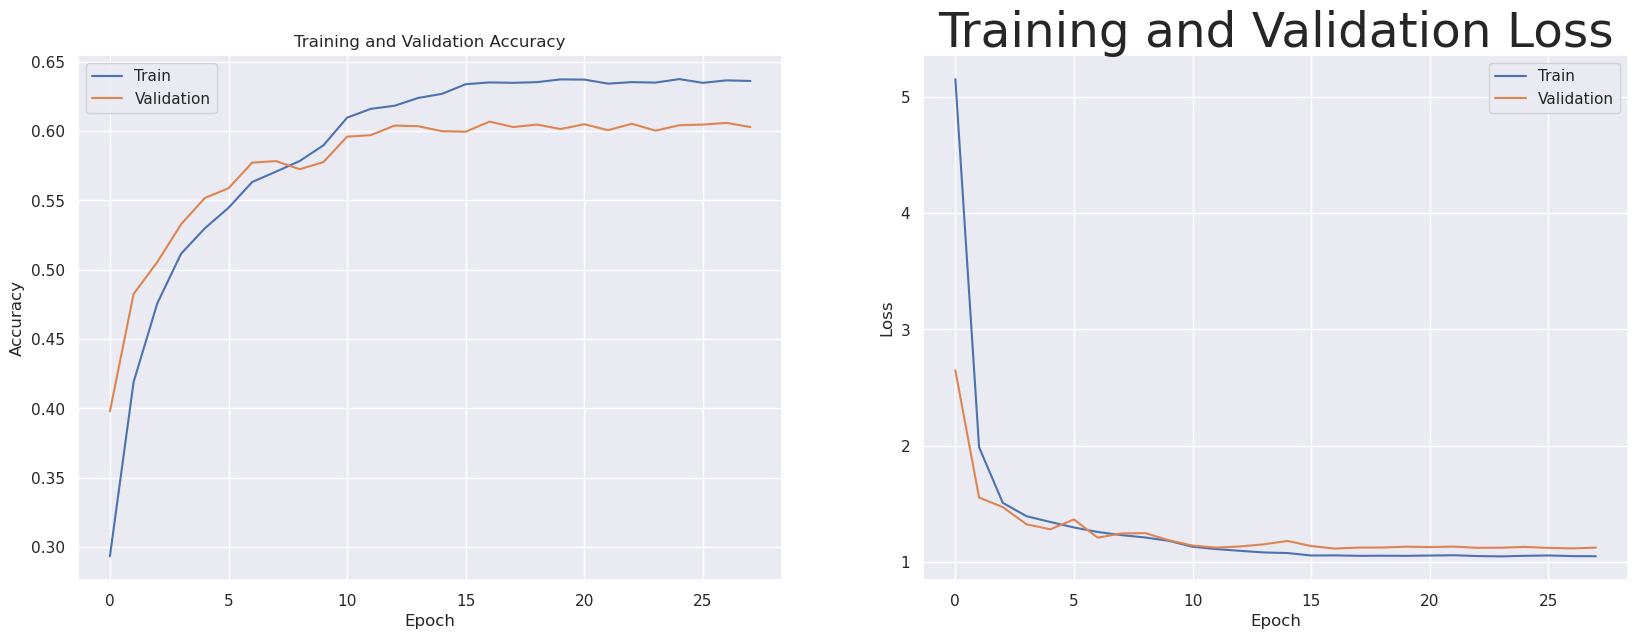

In [24]:
from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)


# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss', fontsize=35)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Load the weights from the saved checkpoint and evaluate

In [25]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name=model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(validation_generator, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

263/263 - 21s - loss: 1.1275 - accuracy: 0.5986 - 21s/epoch - 78ms/step
Restored model, validation accuracy: 59.86%


263/263 [==============================] - 23s 78ms/step
total prediction: 8388

3370 out of 8388 tested images could not be detected properly.
Accuracy of  59.82



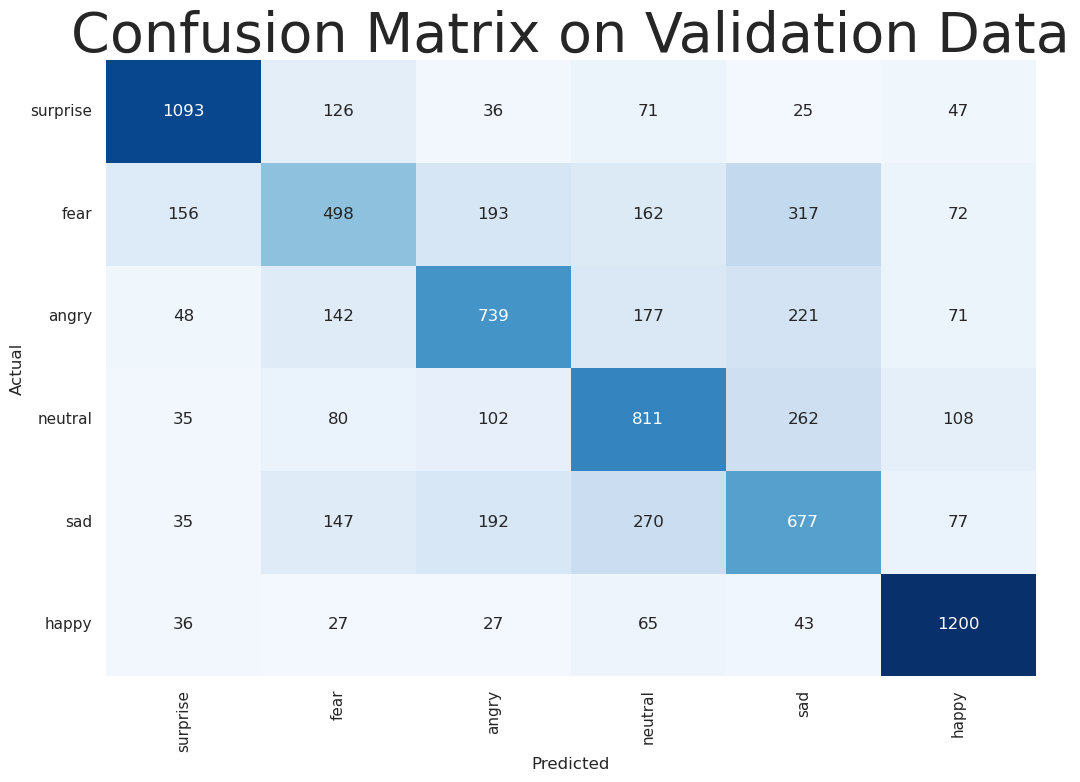

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

    surprise   0.779045  0.781831  0.780436      1398
        fear   0.488235  0.356223  0.411911      1398
       angry   0.573313  0.528612  0.550056      1398
     neutral   0.521208  0.580114  0.549086      1398
         sad   0.438188  0.484263  0.460075      1398
       happy   0.761905  0.858369  0.807265      1398

    accuracy                       0.598236      8388
   macro avg   0.593649  0.598236  0.593138      8388
weighted avg   0.593649  0.598236  0.593138      8388



In [26]:
# 
def ModelPredictionOnTestDataset(test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1) 
    
    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly.\nAccuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix on Validation Data", fontsize=40)
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 6) # create classification report
    print("Classification Report on Validation Data:\n-------------------------------------\n", clr)

#     # Plot the confusion matrix
#         ConfusionMatrix(
#                         label_test=ytrue, 
#                         label_prep=ypred, 
#                         class_count=class_count, 
#                         class_keys=class_keys, 
#                         heada=' for Entire Test Set'
#                         )
        
    return wrong_predictions, total_predictions

wrong_predictions, total_predictions = ModelPredictionOnTestDataset(validation_generator)

1/1 [==============================] - 2s 2s/step
correct prediction: 0.375


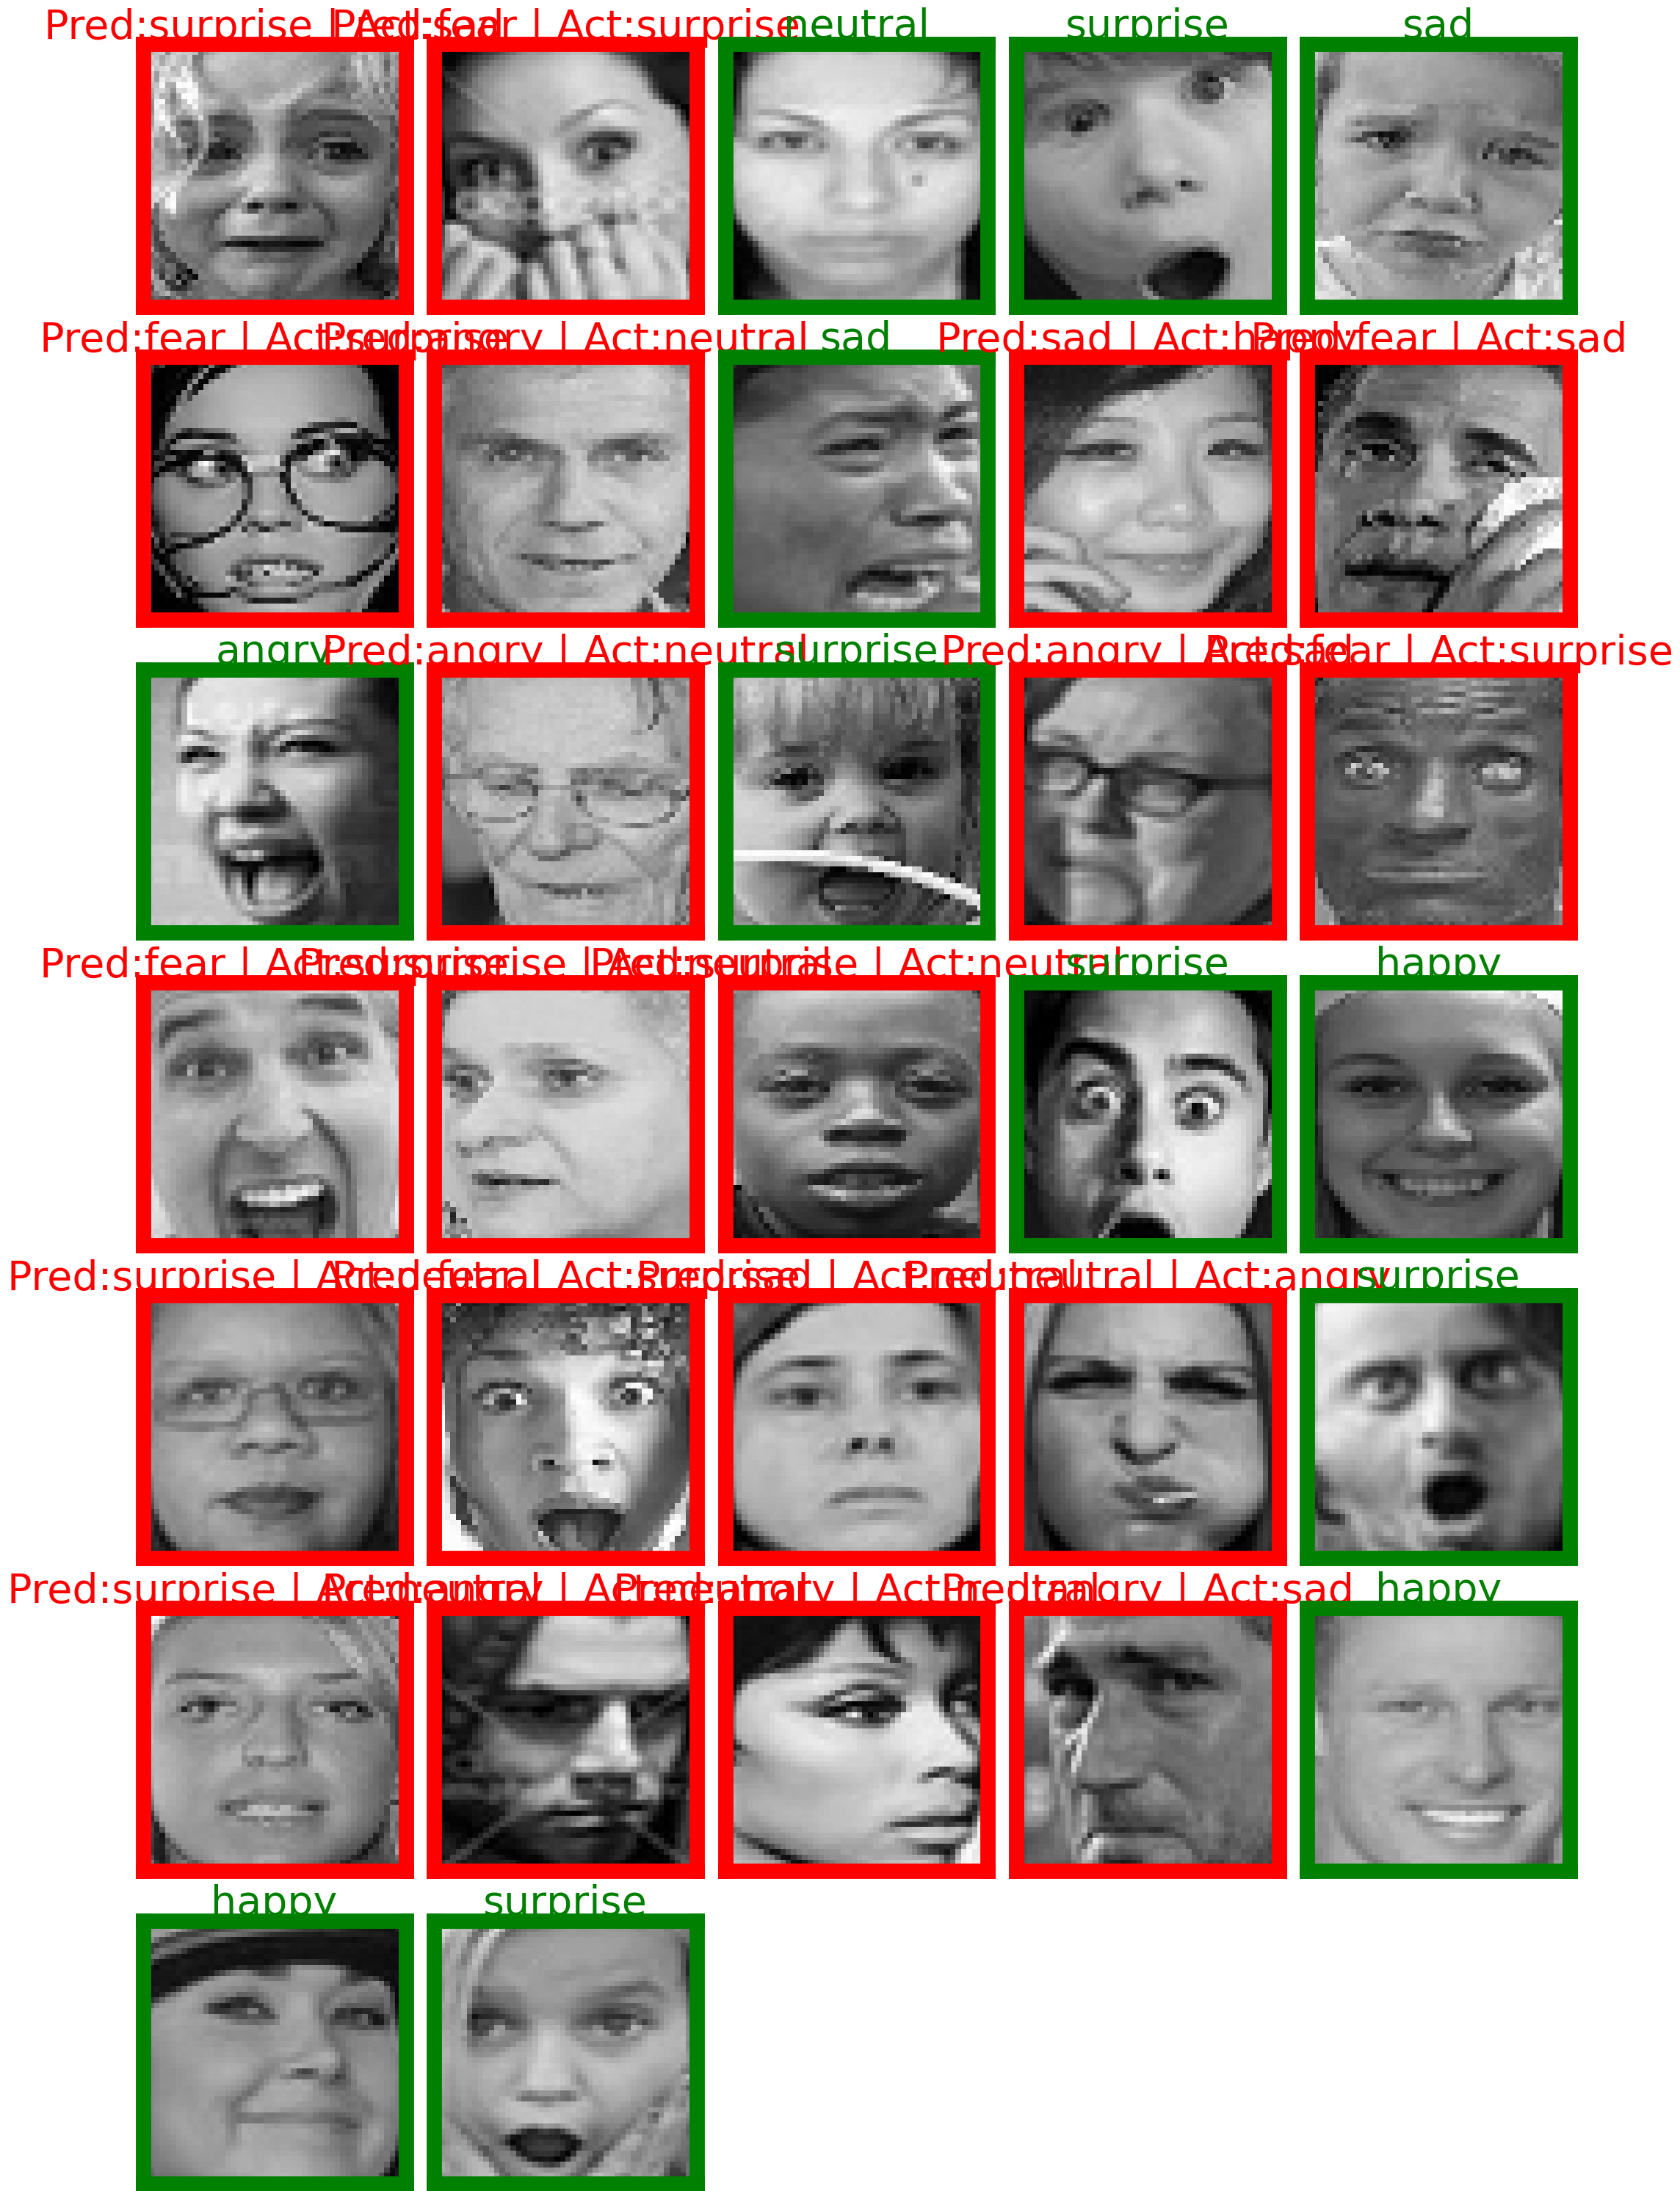

In [27]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection


test_images, test_labels = next(test_generator_shuffled)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/test_batch_size)


def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):    
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id



fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green', 
                    fontsize=40
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red', 
                    fontsize=40
                    )
    plt.tight_layout()